# 문제정의

## 브레인스토밍

- 뉴스 정보 요약하기
- 오늘의 뉴스중 Hot topic 추출하기
- 뉴스별 핵심 키워드 추출하기
- 최근 트랜드 분석하기
- 관심 키워드별 뉴스 브리핑 해주기
- 뉴스별 긍정/부정 감성분석 해보기
- 비슷한 뉴스끼리 그룹핑 하기
- 다양한 방법으로 시각화 해보기

# 데이터 수집
- Naver로부터 수집한 일자별 뉴스기사 불러오기

In [1]:
import json
import pandas as pd

with open("data/20210411.json", encoding="utf-8") as json_file:
    json_data = json.load(json_file)
    newsDf = pd.DataFrame(json_data)
newsDf

,id,date,title,body,source
0,sid1=101&sid2=260&oid=001&aid=0012320653,2021.04.11. 오후 1:52,재건축 기대감 오르는 잠실주공5단지,// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,연합뉴스
1,sid1=100&sid2=268&oid=003&aid=0010440703,2021.04.11. 오전 7:34,"北, 김정은 권력세습 9년 맞아 ""방위력 강화 실현"" 찬양",// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,뉴시스
2,sid1=100&sid2=265&oid=277&aid=0004882656,2021.04.11. 오후 6:44,"임시정부 수립 102주년…野 ""통합의 정치 기대"",""역사 잊어선 안 돼""",// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,아시아경제
3,sid1=103&sid2=241&oid=346&aid=0000039544,2021.04.11. 오후 8:00,눈에도 구멍 생긴다? 갑자기 빛 번쩍이면…,// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,헬스조선
4,sid1=101&sid2=263&oid=014&aid=0004618339,2021.04.11. 오후 6:22,기재부 관료 출신들이 경제정책 마무리… 핵심 브레인이 없다 [재보선 후폭풍],// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,파이낸셜뉴스
...,...,...,...,...,...
4600,sid1=101&sid2=259&oid=011&aid=0003895499,2021.04.11. 오후 4:31,구멍 뚫린 가계부채 관리···DSR서 최소 100조 빠져,// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,서울경제
4601,sid1=101&sid2=310&oid=468&aid=0000760069,2021.04.11. 오후 3:34,"'2030 남성 명품족 겨냥' 롯데百, 스말트 매장 본격 확대",// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,스포츠서울
4602,sid1=102&sid2=255&oid=001&aid=0012320576,2021.04.11. 오후 1:20,탑승객들로 붐비는 공항,// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,연합뉴스
4603,sid1=101&sid2=258&oid=417&aid=0000680475,2021.04.11. 오후 2:10,"거래소, 지난해 불공정거래 180건 적발… 전년 대비 2.3%↑",// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_re...,머니S


# 데이터 전처리

## 특수문자 제거

In [2]:
import re
def CleanArticle(x):
    x = x.replace("// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}\n\n", "").strip()
    return re.sub(r'[^ ㄱ-ㅣ가-힣A-Za-z]', '', x)

newsDf["body"] = newsDf["body"].apply(CleanArticle)
newsDf["title"] = newsDf["title"].apply(CleanArticle)


# 탐색 및 시각화

## 제목에 자주 등장하는 키워드 검색

### 형태소 분석

In [3]:
# return 방식으로 추출하면 너무 느려서 yield로 변경
from konlpy.tag import Hannanum

def GenWordTag(target="title"):
    cls = Hannanum()
    for i in newsDf.index:
        yield newsDf.iloc[i]["id"], cls.pos(newsDf.iloc[i][target])

In [4]:
print("시작")
gen = GenWordTag("title")
newsTitleDict = dict()
for a in gen:
    newsTitleDict[a[0]] = a[1]

    
gen = GenWordTag("body")
newsBodyDict = dict()
for a in gen:
    newsBodyDict[a[0]] = a[1]
print("종료")

시작
종료


### 형태소별  Count

In [5]:
import collections
# 2차원 리스트를 1차원 리스트로 풀기(flatten), 2글자 이상의 명사만 Filter
filterWords = list(filter(lambda e:e[1] == "N" and len(e[0]) > 1, [x for l in list(newsTitleDict.values()) for x in l]))
filterWords = [x[0] for x in filterWords]
wordCounter = collections.Counter(filterWords)
wordCounter = dict(filter(lambda e:e[1] > 1, wordCounter.items()))
sorted(wordCounter.items(), key=lambda item:item[1], reverse=True)

[('배터리', 188),
 ('백신', 147),
 ('접종', 125),
 ('분쟁', 122),
 ('오세훈', 115),
 ('조원', 73),
 ('전국', 58),
 ('속보', 56),
 ('확진자', 56),
 ('부동산', 55),
 ('화재', 55),
 ('신규', 52),
 ('기념식', 52),
 ('승리', 51),
 ('확진', 51),
 ('재개', 49),
 ('최대', 49),
 ('거리두', 48),
 ('재건축', 47),
 ('시장', 47),
 ('미국', 47),
 ('총리', 46),
 ('날씨', 44),
 ('추진', 44),
 ('미얀마', 44),
 ('정부', 43),
 ('정책', 40),
 ('정세균', 40),
 ('기업', 39),
 ('출시', 39),
 ('개최', 38),
 ('논란', 38),
 ('지원', 38),
 ('서울', 37),
 ('진행', 37),
 ('플랫폼', 37),
 ('주년', 36),
 ('합의', 36),
 ('북한', 36),
 ('만원', 35),
 ('전쟁', 35),
 ('비트코', 35),
 ('서울형', 35),
 ('제외', 34),
 ('감염', 33),
 ('아파트', 33),
 ('오늘', 33),
 ('만명', 33),
 ('주간', 32),
 ('효과', 32),
 ('수립', 31),
 ('이유', 31),
 ('관련', 31),
 ('이상', 31),
 ('확산', 30),
 ('대통령', 30),
 ('세월호', 30),
 ('분기', 30),
 ('최고위원', 30),
 ('남양주', 30),
 ('내일', 30),
 ('참석', 29),
 ('현대차', 29),
 ('올해', 29),
 ('도입', 29),
 ('확대', 29),
 ('한국', 28),
 ('쿼드', 28),
 ('시작', 28),
 ('개월', 28),
 ('서비스', 28),
 ('개발', 28),
 ('강화', 27),
 ('김종', 27),
 ('임정수립', 27)

### WordCloud

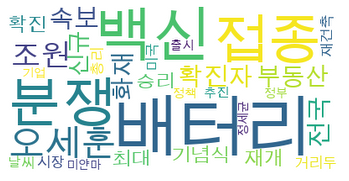

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf',
               background_color='white',
               max_words=30).generate_from_frequencies(wordCounter)
plt.imshow(wc, interpolation='lanczos')
plt.axis('off')
plt.show()

### 최빈 키워드 뉴스 추출

In [75]:
wc.words_

{'배터리': 1.0,
 '백신': 0.7819148936170213,
 '접종': 0.6648936170212766,
 '분쟁': 0.648936170212766,
 '오세훈': 0.6117021276595744,
 '조원': 0.3882978723404255,
 '전국': 0.30851063829787234,
 '속보': 0.2978723404255319,
 '확진자': 0.2978723404255319,
 '부동산': 0.2925531914893617,
 '화재': 0.2925531914893617,
 '신규': 0.2765957446808511,
 '기념식': 0.2765957446808511,
 '승리': 0.2712765957446808,
 '확진': 0.2712765957446808,
 '재개': 0.26063829787234044,
 '최대': 0.26063829787234044,
 '거리두': 0.2553191489361702,
 '재건축': 0.25,
 '시장': 0.25,
 '미국': 0.25,
 '총리': 0.24468085106382978,
 '날씨': 0.23404255319148937,
 '추진': 0.23404255319148937,
 '미얀마': 0.23404255319148937,
 '정부': 0.22872340425531915,
 '정책': 0.2127659574468085,
 '정세균': 0.2127659574468085,
 '기업': 0.2074468085106383,
 '출시': 0.2074468085106383}

## 핵심 키워드 추출(TF-IDF)
- 자주 언급되지만 여러 문서에 언급되는 키워드는 중요하지 않음
- 특정 문서에만 자주 언급되는 키워드가 중요함
- 참고 : https://wikidocs.net/31698

### 형태소별 Count

In [86]:
import collections
# 2차원 리스트를 1차원 리스트로 풀기(flatten), 2글자 이상의 명사만 Filter
filterWords = list(filter(lambda e:e[1] == "N" and len(e[0]) > 1, [x for l in list(newsBodyDict.values()) for x in l]))
filterWords = [x[0] for x in filterWords]
# filterWords[:100]
wordCounter = collections.Counter(filterWords)
wordCounter = dict(filter(lambda e:e[1] > 1, wordCounter.items()))
sorted(wordCounter.items(), key=lambda item:item[1], reverse=True)

[('뉴스', 3964),
 ('미국', 3631),
 ('백신', 3592),
 ('네이버', 2846),
 ('금지', 2753),
 ('시장', 2570),
 ('정부', 2459),
 ('구독', 2267),
 ('배터리', 2242),
 ('접종', 2241),
 ('이번', 1931),
 ('재배포', 1929),
 ('관련', 1735),
 ('지난해', 1730),
 ('서울', 1709),
 ('진행', 1707),
 ('이후', 1557),
 ('이상', 1550),
 ('확진자', 1525),
 ('이노베이션', 1523),
 ('뉴시스', 1491),
 ('경우', 1491),
 ('국내', 1488),
 ('의원', 1475),
 ('대표', 1443),
 ('제공', 1417),
 ('중국', 1405),
 ('기업', 1402),
 ('대통령', 1401),
 ('상황', 1370),
 ('합의', 1350),
 ('사업', 1334),
 ('때문', 1314),
 ('발생', 1292),
 ('시작', 1274),
 ('오후', 1258),
 ('무단', 1249),
 ('올해', 1237),
 ('이날', 1231),
 ('부동산', 1153),
 ('우리', 1153),
 ('서비스', 1149),
 ('문제', 1124),
 ('계획', 1123),
 ('대상', 1117),
 ('관계자', 1108),
 ('필요', 1093),
 ('가격', 1070),
 ('지역', 1057),
 ('정책', 1050),
 ('기준', 1046),
 ('전재', 1040),
 ('시간', 1005),
 ('무단전재', 998),
 ('개발', 997),
 ('추진', 996),
 ('예정', 986),
 ('에너지솔루션', 972),
 ('공개', 968),
 ('국민의힘', 963),
 ('억원', 961),
 ('행사', 957),
 ('분쟁', 939),
 ('결과', 936),
 ('가능성', 923),
 ('오전', 918),
 

### Word set 만들기

In [89]:
wordSet = set(filterWords)
len(wordSet)

80212

### 기사별 형태소가 wordSet에 있는지 체크

In [92]:
print(list(map(lambda k: collections.Counter([w[0] for w in newsBodyDict.get('sid1=101&sid2=260&oid=001&aid=0012320653')])[k], wordSet)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
result = []
for key, value in newsBodyDict.items():
#     print(list(map(lambda k: collections.Counter([w[0] for w in newsDict.get(key)])[k], wordSet)))
#     df = df.append(pd.= Series(list(map(lambda k: collections.Counter([w[0] for w in newsDict.get(key)])[k], wordSet))), ignore_index=True)
    result.append([key] + list(map(lambda k: collections.Counter([w[0] for w in newsBodyDict.get(key)])[k], wordSet)))

In [11]:
countDf = pd.DataFrame(result)
countDf.columns = ["id"] + list(wordSet)

In [13]:
countDf.head()

,id,글꼴,순례길,성범죄자,감염AZ,전시예술,운명,관계,엄수찰스,연쇄,...,시도댓글,장려,이베,일일,황기철,소들녘,콜라보,자율주행,구리시,제비
0,sid1=101&sid2=260&oid=001&aid=0012320653,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sid1=100&sid2=268&oid=003&aid=0010440703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sid1=100&sid2=265&oid=277&aid=0004882656,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,sid1=103&sid2=241&oid=346&aid=0000039544,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sid1=101&sid2=263&oid=014&aid=0004618339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
# countDf[["문재인"]].sum()
for column in countDf.columns:
    if not column == "id":
        print(column)

관장
블랙페이스
증시여전
맑음
스타토익
도입
저평가
신동
부산식
서울시청와대
골프
총리
한계기업
고문
방해
계승
여행
부활
확진청주서
삭제
평범
인적분할
튤립
실제
LGSK합의금
다행
취하년간
접수월
럭키마르쉐
안뚫리
종신연금
늘린다하반기
등록
그알
조성
진행
타령
의혹
시작
월가시각
편의점
파격
물가상승률
상승세열연강판
기대주
시내버스
광주
상승
재킷
네트워크
가구
오류
상하이증시
마련반도체
분출
교민들
무덤
일반음식점
열흘새
자랑한
사흘째
공동전선
야권재편
접근생활
있다LG폰
완료
폭력적
시사일본어학원
당신
굳히기카카오
인싸되기코로
합체
헌신적
비슷
지지의사
타결경쟁협력
재촉
출금
뉴로빅
우리은행네이버
양부모
진화명
사상최고
매출여름
폭리
코앞
난타전
갓먹
주상복합
직격탄
시리즈B
사망자
대장
운동족단백질
병합
포토시민들
빈번
고삐
사고종합
주년주미
아동치과주치의
유입코스피
칼럼
증강
식목
분주한
부과
방랑기
프레즐커피
열었더니건
카드뉴스년
이북
서울시청
대담회
적용
유니레버
분통
조사개선책
진출최대
부고김지형KAI
돈권력세습
내달
코로나세대
구매
자체조사
당권레이스초선
움직인다부동산주식
살인재판
앤톡
당심
월중순크래프톤
케어
효과
한성봉
속보예방접종전문위
팔달구
예방하세요
코리아
운영관여대법
협력사
페이스북
참고
천명대누계
입시비리사모펀드
SK바사
처리능력
조업
중국산백신
고추
함유
뒷타
매듭동결
기대코
시민단체
처벌
평균수명
보고서
관망경민간
양도세
주요뉴스
확진대표
국힘
명용의자
부산CGV
원정대
대다수
청원
거세
오늘날씨
살인사건교통사고
다방
이재명
중재해
이용료
신제품
자유
파국
이랜드
인천시
실전용집권
본보
어쩌지환불
계속
에센스
한국기자협회강원
띄웠지만국민의힘국민의당
버스기사
공모
요구
언론왜
거절
충남
반봄소식
채용절차법
추모행렬
윤호중친
날씨전국
꽃물
진이찬방
뷰티
백신차
제조
명평균
사망누적
풀리나부분
접종계획
나무심기
충전기
안날까
전수조사
성형수술
긴급
탈친문이냐
신분증
우리금융
국민연금
하세요간편한
간편
대형
랠리종합
용지
재개사법농

도종환황기철김원웅
최적화
퇴근길
방역미래차소부장
겨울
자산어보
SOS종합
충청
안주
기획전
화창
자동차보수용
기후정상회의
바르셀로
대단
연계
사자카카오
방지피해복구
교회
준비
삼성TSMC
물량
약물중독
러시아국장
대한상
제페토
노동자자동차업계
총포
벽창호
팝콘옛
참꽃
모듈러
주요기업
르노삼성
설비
무인헬기
석판
주상절리재인폭포
산하기관장
스타트UP놓친
동맹
도서
일평균
갤러리아
난립
필요해
편가르
에티오피아
연관
서울대
꽃지해안공원
노동자자동차산업
발사관
맞손CrPET
진화검
매개
대구가톨릭대
경록
공시줍줍
지하
모색주호영
복당
저장탱크
스타트업장례만큼
시작백신접종
구직촉진수당
쉴틈없
시공사
용기
라벨링
저지
해빙기
폭행살해
탱크
해커스
자동
여권
순매
조용철
가팔라졌다
사망또
주의년간
탐앤탐스
준조세
증가고속도로
캐릭터
우주
짚불
세탁기
배출처리시설
운행중단
스마트
리뷰캔맥주
제외종합
주류
해충
페트병
당국
국민의힘국민의당통합
질환
해커스한국사
심호흡종합
컬러
감염경로
색이재명
행군언제
도약
추돌
발사하루
내륙산지
공무직기간제
흉물
충북서
몸캠피싱
대북전단법
않다중국
접종재개
벌금폭탄
강신웅
격려금현대차
명승
토요타
노동신문
중대재해처벌법
대북전단
행안부
버추얼
고령
구속
거리두기방역당국
강원
보건복지부
밀맥주냐
대구펜문학
쇄신론
경고에도봄볕
속도전친문
안전점검
극미량
징역
한병
반성문
미나리
말레이시
업계
재보선당
여전대
만성질환
펀드올해
자급제폰
경우
뒷받침
일만
기록경신
영화계
보완
녹유
포상
접수
러우크라
재판부
금메달
지적질책
가중
날씨인천
한국관
수원
고심대정부질문
연방대법원
왕손
가산자산
기준
현지화특성화
등대
고객사
융자
시동
속보방역당국
무료
특별방역회의경제장관회의
RC유나
힐링로드
이해충돌
안간힘
유력
적발압수
정치로종합
도심하천
합당론
세계화를김영만
고대했다즉각
비비
NH투
짭짤
참사
축하
중부여성새로일하기센터
보수용
주의내
해삼
임시
존재
퇴출해주세요
파워트레인마일드
한국온다
용품
훼손기업
임진강산수유마을백둔천
경남서
노동자차산업
신선식

삼성창원병원
청약인근
이것
김천시
아리바이오
집중조명이재명표
부재중
현대차효성LS대림재계
천원
장수시대
로열티
전국
계속거리두
연합뉴스TV
현대모비스LG전자네이버
협조해달라
무명가수
필름형
데카론M
임원들
스토리제로콜라
뛰어오세훈발
국민의힘국민의당
최다알짜
우선주리딩방
로또
차단이스트시큐리티
눌리고현대차기아
미운털
카카오엔터
발생누적
한성대
전조
개그
재개발
수혜
내륙
살인사건대
가속도
조형물
재검토
불붙
출장
모성
ㅂㅅㅇㄱ
소방산업
외교멘토
미다스
의견
변별력
집단감염감염원
입주권
흉기
한센인마
그에따른
북도민
검찰
통합
약병특혜
설립하겠다년만
리뉴얼
발끈한
명충남
시작법정
스튜디오드래곤
세계화
허가감독
수창청춘맨숀
현수막
성찰
유흥주점
산학협력
정경심
조개
파로호
롯데제과
특수고용직
태양광
접종
아침날씨
피엘라벤
박진식
언니들
황사미세먼지
추가발생누적
미소
환영전국적
인천
캐디
회사채
축하최태원정의선구광모
찬양
익산서
심각
해양경찰
다이어터
안보실장
나우
윤호중안규백박완주
발생격리
구체
영향리니지M
영상
수혜입
변경상보
개최
초등교과서
대신관
해외여행
순환경제
봄비일부
정비
선출
봄철
라이프
년형
환상
매달
초보
추진네이버
최저가무료배송
달력
아시아계
리파이닝
미뤘는데불행
이벤트
우수
러너
부동산정책협의회
명품
포착
민해정수
코스피
지재권일자리
접종재개혈전위험
경영대학원
초선돌풍
견주
공무원
띄우기애민정신결사옹위
조정
착용해
치킨집
도서관
일가치
도면
꺼낼라
회계심사회계법
인구
사설암호화폐거래소
발생학교병원
슈퍼기업
강태공한밤중
혈전
폭증
봄바람
기재부
줄줄이툰베리
유통기한
누리꾼
화재
승려
개정작업
남아공
화이자
불수족관
경고했지만봄나들이
경영관여
에너지솔루션
신념
총기비극
것종합
가스시설
인방
임아영경향신문
마산항
명명
편입
찰스
골머리
물망청와대
환장
흥행
LG엔솔
대안학교
감사오늘
안전간편
SOS한국
청년층
구도
철도도
둔화매수
만원차
한국언론진흥재단
영향줄까
아스트라제네카
세금
요르단
디디추싱뉴욕
슈퍼개미
치닫다가더
협정보
소형주택
적신호
비즈니스

혼합
미래혁신위원
확정
절반
최다만천명
홍영표
협상
소비자물가
안올라요
한강공원
회화
소액주주들
조깅해요V컬러링
맘스터치
신분
진단서
신호
주의보QR코드
반말
무색
철수설
정계
무궁화공원
최초웹툰
방법
확진거리두
만큼
사요편의점
호반써밋
금감원서
문닫는다
드러냈다주소
종목
거절하자과일
날아오른다
종전SK
되풀이
여당
미상
간호사
지속시내버스
경쟁
평택
토론대회
권고
다음주
마련해
가뭄
대형중소
용인시완장서리유운매산
황광희
한반
원내대표
줍깅하
민홍철
금지법
교사명학생
어제
가열
부산미래혁신위
폭증신규확진
지방선거
합의공식발표
온기
굿즈
확진주
진행중
차질
시민실험실
청송
반도체
메트로시티
공모전
떠나보낸
속보LG엔솔SK이노
환율
대구보건대
육군사관학교
꼼짝마
입건
분란
확진대학생
프라페
브랜드
온데이팜
방역경제회의이르
주간증시전망어닝시즌
중국것
비대위원장
일지
차량
빈민
반독점
대비
공사
독설왜
촉촉
상황
해저터널
날씨전북
시장부동산코
대립
슈퍼리치
권익위
구사일생해경
전라남
임대차분쟁조정
내일날씨전국
블록
음식
승인대상
수정꽃병
네거티브
시험
리얼
인산인해
회부
택배
하반기
기대감
신진도항
안전성
이슈분석K배터리
더티
독성물질
유샵
백운산
뒤끝
협력동결자금
오피스
반도체회의미국
재건
화면낭독기
범위
평택석정
작가
롯데캐슬
주가
전술해전
벗었다이집트
봉사정신
국정안정
조세저항
대사건
중국발
보람양
양국
인미만
바이러스
주제
삼성LG
경남
메르세데스벤츠
감염누적
중국산
관악경기
우크라
댄스강남
센드버드
점유율
민심
결혼
누계
담합
조로열티
방짜유
DL이앤씨
생중계
싸늘
평가종합
끝조
삼의사
검색
집단학살최소
훼손기업한계기업
브이넥
MA협업
몰수
접촉
희생자
한국항공우주산업
신경계
에이모
공사평양시
광복회장임시정부
일관
웹예능
확진놀이시설교회
판정청사
고가호
선물옥돌
개통
예방조치
위반차량
정상화종합
승계장자
감염불구
측면
폭행국민의힘
항쟁
카드
공사도급계약
주식
fn이사람
국민의힘오세훈
질병
쌍용차
혼수
성균관대현대로보틱스
인정
조직
박격포유탄발사기
이상반응
폭

## 자주 등장하는 단어 빈도수 추출

## 특정 키워드 언급 기사 추출

## 기사 요약

## 감성 분석

## 비슷한 기사끼리 그룹핑

## Pie, Bar, Headmap, etc...

## 언론사, 카테고리별 요약

# 모델링

# 모델 평가 및 검증

# 인사이트 도출

# 결론